In [1]:
import json
import warnings

warnings.filterwarnings("ignore")

import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
from matplotlib.colors import LogNorm
from tqdm import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15, 8)
legend_fontsize = 16

In [2]:
%load_ext autoreload
%autoreload 2

## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:

* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
* игрок может совершать одно из двух действий:
* hit — взять ещё одну карту;
* stand — не брать больше карт;
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).


Именно этот простейший вариант блекджека реализован в OpenAI Gym: https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

1) Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

2) Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

3) Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [3]:
def pi_dummy(state):
    if state[0] < 19:
        return True
    else:
        return False


def conduct_experiments_pi_dummy(env, pi, num_experiments):
    total_reward = []
    for _ in range(num_experiments):
        observation = env.reset()
        done = False
        while not done:
            observation, reward, done, info = env.step(pi(observation))
        total_reward.append(reward)
    env.close()
    return np.mean(total_reward)

In [96]:
env = gym.make("Blackjack-v0", natural=True)

In [97]:
num_experiments = 500_000
mean_reward = conduct_experiments_pi_dummy(env, pi_dummy, num_experiments)
print(f"Средний выигрыш от простой стратегии равен {mean_reward}")

Средний выигрыш от простой стратегии равен -0.184925


In [98]:
# запишем все возможные состояния и действия

A = [True, False]
S = []
min_player_hand = 4
max_player_hand = 31
min_dealer_hand = 1
max_dealer_hand = 10
for i in range(min_player_hand, max_player_hand + 1):
    for j in range(min_dealer_hand, max_dealer_hand + 1):
        if 12 <= i <= 21:
            S.append((i, j, True))
            S.append((i, j, False))
        else:
            S.append((i, j, False))

nS, nA = len(S), len(A)
S2idx = {s: i for i, s in enumerate(S)}

In [3]:
def Q_learning_episode(env, pi, Q, alpha=0.05, epsilon=0.0, gamma=1):
    observation = env.reset()
    s = S2idx[observation]

    done = False
    while not done:
        pi = compute_policy_by_Q(env, Q)
        a = pi[s] if np.random.rand() > epsilon else np.random.randint(nA)

        observation, reward, done, info = env.step(a)
        s_prime = S2idx[observation]

        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max(Q[s_prime]) - Q[s][a])
        s = s_prime
    #         if done:
    #             break
    return Q


def compute_policy_by_Q(env, Q, gamma=1.0):
    return np.argmax(Q, axis=1)


def Q_learning(env, total_episodes, alpha, epsilon, gamma):
    Q = np.zeros((nS, nA))
    pi = compute_policy_by_Q(env, Q)

    for n in range(total_episodes):
        Q = Q_learning_episode(env, pi, Q, alpha, epsilon, gamma)

    return Q


def conduct_experiments_pi(env, pi, num_experiments):
    total_reward = []
    for _ in range(num_experiments):
        observation = env.reset()
        s = S2idx[observation]
        done = False
        while not done:
            observation, reward, done, info = env.step(pi[s])
            s = S2idx[observation]
        total_reward.append(reward)
    env.close()
    return np.mean(total_reward)

In [100]:
total_episodes = 100_000
alpha = 0.02
epsilon = 0.1
gamma = 1
Q = Q_learning(
    env, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma
)
pi = compute_policy_by_Q(env, Q)

num_experiments = 500_000
mean_reward = conduct_experiments_pi(env, pi, num_experiments)
print(f"Средний выигрыш от стратегии Q-learning равен {mean_reward}")

Средний выигрыш от стратегии Q-learning равен -0.151022


Подбор гиперпараметров:

In [16]:
epsilon = np.arange(0.05, 1, 0.05)
alpha = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01]
for e in tqdm(epsilon):
    for a in alpha:
        Q = Q_learning(
            env, total_episodes=total_episodes, alpha=a, epsilon=e, gamma=gamma
        )
        pi = compute_policy_by_Q(env, Q)
        num_experiments = 50_000
        mean_reward = conduct_experiments_pi(env, pi, num_experiments)
        print(f"Epsillon = {e}, alpha = {a}, reward = {mean_reward}")

  0%|          | 0/19 [00:00<?, ?it/s]

Epsillon = 0.05, alpha = 1e-05, reward = -0.05442
Epsillon = 0.05, alpha = 5e-05, reward = -0.06222
Epsillon = 0.05, alpha = 0.0001, reward = -0.08779
Epsillon = 0.05, alpha = 0.0005, reward = -0.06837
Epsillon = 0.05, alpha = 0.001, reward = -0.07113
Epsillon = 0.05, alpha = 0.005, reward = -0.15948


  5%|▌         | 1/19 [01:23<25:09, 83.85s/it]

Epsillon = 0.05, alpha = 0.01, reward = -0.15785
Epsillon = 0.1, alpha = 1e-05, reward = -0.05954
Epsillon = 0.1, alpha = 5e-05, reward = -0.06901
Epsillon = 0.1, alpha = 0.0001, reward = -0.06623
Epsillon = 0.1, alpha = 0.0005, reward = -0.06902
Epsillon = 0.1, alpha = 0.001, reward = -0.07985
Epsillon = 0.1, alpha = 0.005, reward = -0.16567


 11%|█         | 2/19 [02:48<23:56, 84.50s/it]

Epsillon = 0.1, alpha = 0.01, reward = -0.15763
Epsillon = 0.15000000000000002, alpha = 1e-05, reward = -0.04452
Epsillon = 0.15000000000000002, alpha = 5e-05, reward = -0.05288
Epsillon = 0.15000000000000002, alpha = 0.0001, reward = -0.05137
Epsillon = 0.15000000000000002, alpha = 0.0005, reward = -0.07058
Epsillon = 0.15000000000000002, alpha = 0.001, reward = -0.0701
Epsillon = 0.15000000000000002, alpha = 0.005, reward = -0.1349


 16%|█▌        | 3/19 [04:13<22:29, 84.36s/it]

Epsillon = 0.15000000000000002, alpha = 0.01, reward = -0.15161
Epsillon = 0.2, alpha = 1e-05, reward = -0.07992
Epsillon = 0.2, alpha = 5e-05, reward = -0.04316
Epsillon = 0.2, alpha = 0.0001, reward = -0.07826
Epsillon = 0.2, alpha = 0.0005, reward = -0.05499
Epsillon = 0.2, alpha = 0.001, reward = -0.07618
Epsillon = 0.2, alpha = 0.005, reward = -0.14537


 21%|██        | 4/19 [05:38<21:14, 84.95s/it]

Epsillon = 0.2, alpha = 0.01, reward = -0.12724
Epsillon = 0.25, alpha = 1e-05, reward = -0.05312
Epsillon = 0.25, alpha = 5e-05, reward = -0.07275
Epsillon = 0.25, alpha = 0.0001, reward = -0.05964
Epsillon = 0.25, alpha = 0.0005, reward = -0.05288
Epsillon = 0.25, alpha = 0.001, reward = -0.08215
Epsillon = 0.25, alpha = 0.005, reward = -0.14135


 26%|██▋       | 5/19 [07:05<19:55, 85.42s/it]

Epsillon = 0.25, alpha = 0.01, reward = -0.16915
Epsillon = 0.3, alpha = 1e-05, reward = -0.05811
Epsillon = 0.3, alpha = 5e-05, reward = -0.05001
Epsillon = 0.3, alpha = 0.0001, reward = -0.04329
Epsillon = 0.3, alpha = 0.0005, reward = -0.05102
Epsillon = 0.3, alpha = 0.001, reward = -0.07107
Epsillon = 0.3, alpha = 0.005, reward = -0.14327


 32%|███▏      | 6/19 [08:29<18:26, 85.15s/it]

Epsillon = 0.3, alpha = 0.01, reward = -0.12227
Epsillon = 0.35000000000000003, alpha = 1e-05, reward = -0.05318
Epsillon = 0.35000000000000003, alpha = 5e-05, reward = -0.07312
Epsillon = 0.35000000000000003, alpha = 0.0001, reward = -0.06274
Epsillon = 0.35000000000000003, alpha = 0.0005, reward = -0.05376
Epsillon = 0.35000000000000003, alpha = 0.001, reward = -0.0763
Epsillon = 0.35000000000000003, alpha = 0.005, reward = -0.1552


 37%|███▋      | 7/19 [09:54<17:00, 85.01s/it]

Epsillon = 0.35000000000000003, alpha = 0.01, reward = -0.16664
Epsillon = 0.4, alpha = 1e-05, reward = -0.04343
Epsillon = 0.4, alpha = 5e-05, reward = -0.0555
Epsillon = 0.4, alpha = 0.0001, reward = -0.05518
Epsillon = 0.4, alpha = 0.0005, reward = -0.04565
Epsillon = 0.4, alpha = 0.001, reward = -0.06425
Epsillon = 0.4, alpha = 0.005, reward = -0.13994


 42%|████▏     | 8/19 [11:16<15:26, 84.22s/it]

Epsillon = 0.4, alpha = 0.01, reward = -0.11789
Epsillon = 0.45, alpha = 1e-05, reward = -0.04862
Epsillon = 0.45, alpha = 5e-05, reward = -0.03952
Epsillon = 0.45, alpha = 0.0001, reward = -0.05947
Epsillon = 0.45, alpha = 0.0005, reward = -0.05056
Epsillon = 0.45, alpha = 0.001, reward = -0.0365
Epsillon = 0.45, alpha = 0.005, reward = -0.12822


 47%|████▋     | 9/19 [12:40<14:01, 84.15s/it]

Epsillon = 0.45, alpha = 0.01, reward = -0.14799
Epsillon = 0.5, alpha = 1e-05, reward = -0.03999
Epsillon = 0.5, alpha = 5e-05, reward = -0.05926
Epsillon = 0.5, alpha = 0.0001, reward = -0.04058
Epsillon = 0.5, alpha = 0.0005, reward = -0.05708
Epsillon = 0.5, alpha = 0.001, reward = -0.04598
Epsillon = 0.5, alpha = 0.005, reward = -0.13018


 53%|█████▎    | 10/19 [14:06<12:40, 84.46s/it]

Epsillon = 0.5, alpha = 0.01, reward = -0.16104
Epsillon = 0.55, alpha = 1e-05, reward = -0.04944
Epsillon = 0.55, alpha = 5e-05, reward = -0.04848
Epsillon = 0.55, alpha = 0.0001, reward = -0.05025
Epsillon = 0.55, alpha = 0.0005, reward = -0.04061
Epsillon = 0.55, alpha = 0.001, reward = -0.06209
Epsillon = 0.55, alpha = 0.005, reward = -0.12292


 58%|█████▊    | 11/19 [15:30<11:14, 84.36s/it]

Epsillon = 0.55, alpha = 0.01, reward = -0.14926
Epsillon = 0.6000000000000001, alpha = 1e-05, reward = -0.0511
Epsillon = 0.6000000000000001, alpha = 5e-05, reward = -0.04237
Epsillon = 0.6000000000000001, alpha = 0.0001, reward = -0.03068
Epsillon = 0.6000000000000001, alpha = 0.0005, reward = -0.03172
Epsillon = 0.6000000000000001, alpha = 0.001, reward = -0.05553
Epsillon = 0.6000000000000001, alpha = 0.005, reward = -0.11133


 63%|██████▎   | 12/19 [16:54<09:49, 84.22s/it]

Epsillon = 0.6000000000000001, alpha = 0.01, reward = -0.15597
Epsillon = 0.6500000000000001, alpha = 1e-05, reward = -0.04091
Epsillon = 0.6500000000000001, alpha = 5e-05, reward = -0.02981
Epsillon = 0.6500000000000001, alpha = 0.0001, reward = -0.04597
Epsillon = 0.6500000000000001, alpha = 0.0005, reward = -0.03844
Epsillon = 0.6500000000000001, alpha = 0.001, reward = -0.05812
Epsillon = 0.6500000000000001, alpha = 0.005, reward = -0.12801


 68%|██████▊   | 13/19 [18:18<08:25, 84.20s/it]

Epsillon = 0.6500000000000001, alpha = 0.01, reward = -0.1228
Epsillon = 0.7000000000000001, alpha = 1e-05, reward = -0.03187
Epsillon = 0.7000000000000001, alpha = 5e-05, reward = -0.05122
Epsillon = 0.7000000000000001, alpha = 0.0001, reward = -0.03037
Epsillon = 0.7000000000000001, alpha = 0.0005, reward = -0.03595
Epsillon = 0.7000000000000001, alpha = 0.001, reward = -0.04063
Epsillon = 0.7000000000000001, alpha = 0.005, reward = -0.08135


 74%|███████▎  | 14/19 [19:44<07:03, 84.65s/it]

Epsillon = 0.7000000000000001, alpha = 0.01, reward = -0.11837
Epsillon = 0.7500000000000001, alpha = 1e-05, reward = -0.04008
Epsillon = 0.7500000000000001, alpha = 5e-05, reward = -0.03762
Epsillon = 0.7500000000000001, alpha = 0.0001, reward = -0.04225
Epsillon = 0.7500000000000001, alpha = 0.0005, reward = -0.03955
Epsillon = 0.7500000000000001, alpha = 0.001, reward = -0.04108
Epsillon = 0.7500000000000001, alpha = 0.005, reward = -0.12516


 79%|███████▉  | 15/19 [21:13<05:44, 86.02s/it]

Epsillon = 0.7500000000000001, alpha = 0.01, reward = -0.11424
Epsillon = 0.8, alpha = 1e-05, reward = -0.03895
Epsillon = 0.8, alpha = 5e-05, reward = -0.03302
Epsillon = 0.8, alpha = 0.0001, reward = -0.03765
Epsillon = 0.8, alpha = 0.0005, reward = -0.03129
Epsillon = 0.8, alpha = 0.001, reward = -0.03113
Epsillon = 0.8, alpha = 0.005, reward = -0.11845


 84%|████████▍ | 16/19 [22:37<04:16, 85.64s/it]

Epsillon = 0.8, alpha = 0.01, reward = -0.12808
Epsillon = 0.8500000000000001, alpha = 1e-05, reward = -0.03803
Epsillon = 0.8500000000000001, alpha = 5e-05, reward = -0.03718
Epsillon = 0.8500000000000001, alpha = 0.0001, reward = -0.04468
Epsillon = 0.8500000000000001, alpha = 0.0005, reward = -0.03288
Epsillon = 0.8500000000000001, alpha = 0.001, reward = -0.03322
Epsillon = 0.8500000000000001, alpha = 0.005, reward = -0.08798


 89%|████████▉ | 17/19 [24:03<02:51, 85.58s/it]

Epsillon = 0.8500000000000001, alpha = 0.01, reward = -0.11475
Epsillon = 0.9000000000000001, alpha = 1e-05, reward = -0.03405
Epsillon = 0.9000000000000001, alpha = 5e-05, reward = -0.03217
Epsillon = 0.9000000000000001, alpha = 0.0001, reward = -0.02458
Epsillon = 0.9000000000000001, alpha = 0.0005, reward = -0.03354
Epsillon = 0.9000000000000001, alpha = 0.001, reward = -0.03226
Epsillon = 0.9000000000000001, alpha = 0.005, reward = -0.0922


 95%|█████████▍| 18/19 [25:29<01:25, 85.63s/it]

Epsillon = 0.9000000000000001, alpha = 0.01, reward = -0.14846
Epsillon = 0.9500000000000001, alpha = 1e-05, reward = -0.02786
Epsillon = 0.9500000000000001, alpha = 5e-05, reward = -0.0306
Epsillon = 0.9500000000000001, alpha = 0.0001, reward = -0.03631
Epsillon = 0.9500000000000001, alpha = 0.0005, reward = -0.04687
Epsillon = 0.9500000000000001, alpha = 0.001, reward = -0.02839
Epsillon = 0.9500000000000001, alpha = 0.005, reward = -0.08027


100%|██████████| 19/19 [26:53<00:00, 84.92s/it]

Epsillon = 0.9500000000000001, alpha = 0.01, reward = -0.14879


In [101]:
total_episodes = 100_000
alpha = 1e-05
epsilon = 0.95
gamma = 1
Q = Q_learning(
    env, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma
)
pi = compute_policy_by_Q(env, Q)

num_experiments = 500_000
mean_reward = conduct_experiments_pi(env, pi, num_experiments)
print(f"Средний выигрыш от стратегии Q-learning с подобранными гиперпараметрами равен {mean_reward}")

Средний выигрыш от стратегии Q-learning с подобранными гиперпараметрами равен -0.034863


In [4]:
def plot_learning(
    total_episodes, total_distribution, alpha=0.00015, epsilon=0.9, gamma=1
):
    Q_all = [np.zeros((nS, nA))] * total_distribution
    pi_all = [compute_policy_by_Q(env, Q) for Q in Q_all]
    mean_episodes_reward = []
    for _ in tqdm(range(total_episodes)):
        episode_reward = []
        for i in range(total_distribution):
            Q_all[i] = Q_learning_episode(
                env, pi_all[i], Q_all[i], alpha=alpha, epsilon=epsilon, gamma=gamma
            )
            pi_all[i] = compute_policy_by_Q(env, Q_all[i])
            episode_reward.append(conduct_experiments_pi(env, pi_all[i], 100))
        mean_episodes_reward.append(np.mean(episode_reward))
    return mean_episodes_reward

In [103]:
total_episodes = 1000
total_distribution = 50
mean_episodes_reward = plot_learning(total_episodes, total_distribution)

100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


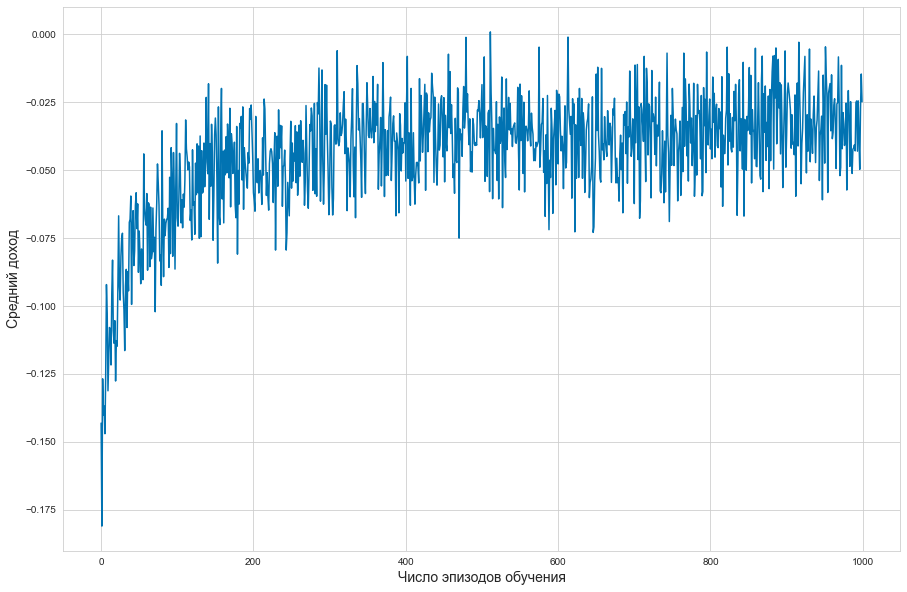

In [104]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_xlabel("Число эпизодов обучения", fontsize=14)
ax.set_ylabel("Средний доход", fontsize=14)

ax.plot(range(total_episodes), mean_episodes_reward)

plt.show()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

* double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4) Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

5) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [5]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackDoubleEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=True, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:  # double
            done = True
            self.player.append(draw_card(self.np_random))
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * 2
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [106]:
env = BlackjackDoubleEnv(natural=True)

In [107]:
# запишем все возможные состояния и действия

A = [1, 0, 2]
S = []
min_player_hand = 4
max_player_hand = 31
min_dealer_hand = 1
max_dealer_hand = 10
for i in range(min_player_hand, max_player_hand + 1):
    for j in range(min_dealer_hand, max_dealer_hand + 1):
        if 12 <= i <= 21:
            S.append((i, j, True))
            S.append((i, j, False))
        else:
            S.append((i, j, False))

nS, nA = len(S), len(A)
S2idx = {s: i for i, s in enumerate(S)}

In [108]:
total_episodes = 100_000
alpha = 1e-05
epsilon = 0.95
gamma = 1
Q = Q_learning(
    env, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma
)
pi = compute_policy_by_Q(env, Q)

num_experiments = 500_000
mean_reward = conduct_experiments_pi(env, pi, num_experiments)
print(f"Средний выигрыш от стратегии с удвоением Q-learning равен {mean_reward}")

Средний выигрыш от стратегии с удвоением Q-learning равен -0.030954


Подбор гиперпараметров:

In [32]:
epsilon = np.arange(0.75, 1, 0.05)
alpha = [0.00001, 0.00003, 0.00005, 0.0001, 0.0005]
for e in tqdm(epsilon):
    for a in alpha:
        Q = Q_learning(
            env, total_episodes=total_episodes, alpha=a, epsilon=e, gamma=gamma
        )
        pi = compute_policy_by_Q(env, Q)
        num_experiments = 50_000
        mean_reward = conduct_experiments_pi(env, pi, num_experiments)
        print(f"Epsillon = {e}, alpha = {a}, reward = {mean_reward}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epsillon = 0.75, alpha = 1e-05, reward = -0.03324
Epsillon = 0.75, alpha = 3e-05, reward = -0.04291
Epsillon = 0.75, alpha = 5e-05, reward = -0.03697
Epsillon = 0.75, alpha = 0.0001, reward = -0.03497


 20%|██        | 1/5 [01:02<04:09, 62.33s/it]

Epsillon = 0.75, alpha = 0.0005, reward = -0.04838
Epsillon = 0.8, alpha = 1e-05, reward = -0.04099
Epsillon = 0.8, alpha = 3e-05, reward = -0.03125
Epsillon = 0.8, alpha = 5e-05, reward = -0.04168
Epsillon = 0.8, alpha = 0.0001, reward = -0.02655


 40%|████      | 2/5 [02:01<03:01, 60.60s/it]

Epsillon = 0.8, alpha = 0.0005, reward = -0.04106
Epsillon = 0.8500000000000001, alpha = 1e-05, reward = -0.03426
Epsillon = 0.8500000000000001, alpha = 3e-05, reward = -0.02228
Epsillon = 0.8500000000000001, alpha = 5e-05, reward = -0.02739
Epsillon = 0.8500000000000001, alpha = 0.0001, reward = -0.03336


 60%|██████    | 3/5 [03:00<01:59, 59.94s/it]

Epsillon = 0.8500000000000001, alpha = 0.0005, reward = -0.02544
Epsillon = 0.9000000000000001, alpha = 1e-05, reward = -0.02794
Epsillon = 0.9000000000000001, alpha = 3e-05, reward = -0.03729
Epsillon = 0.9000000000000001, alpha = 5e-05, reward = -0.02792
Epsillon = 0.9000000000000001, alpha = 0.0001, reward = -0.02385


 80%|████████  | 4/5 [04:00<00:59, 59.84s/it]

Epsillon = 0.9000000000000001, alpha = 0.0005, reward = -0.03622
Epsillon = 0.9500000000000002, alpha = 1e-05, reward = -0.03323
Epsillon = 0.9500000000000002, alpha = 3e-05, reward = -0.01701
Epsillon = 0.9500000000000002, alpha = 5e-05, reward = -0.01675
Epsillon = 0.9500000000000002, alpha = 0.0001, reward = -0.02413


100%|██████████| 5/5 [05:02<00:00, 60.57s/it]

Epsillon = 0.9500000000000002, alpha = 0.0005, reward = -0.01047


In [109]:
total_episodes = 100_000
alpha = 5e-05
epsilon = 0.95
gamma = 1
Q = Q_learning(
    env, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma
)
pi = compute_policy_by_Q(env, Q)

num_experiments = 500_000
mean_reward = conduct_experiments_pi(env, pi, num_experiments)
print(f"Средний выигрыш от стратегии с удвоением Q-learning с подобранными гиперпараметрами равен {mean_reward}")

Средний выигрыш от стратегии с удвоением Q-learning с подобранными гиперпараметрами равен -0.026522


In [110]:
total_episodes = 1000
total_distribution = 50
mean_episodes_reward = plot_learning(total_episodes, total_distribution, 3e-05, 0.95)

100%|██████████| 1000/1000 [06:14<00:00,  2.67it/s]


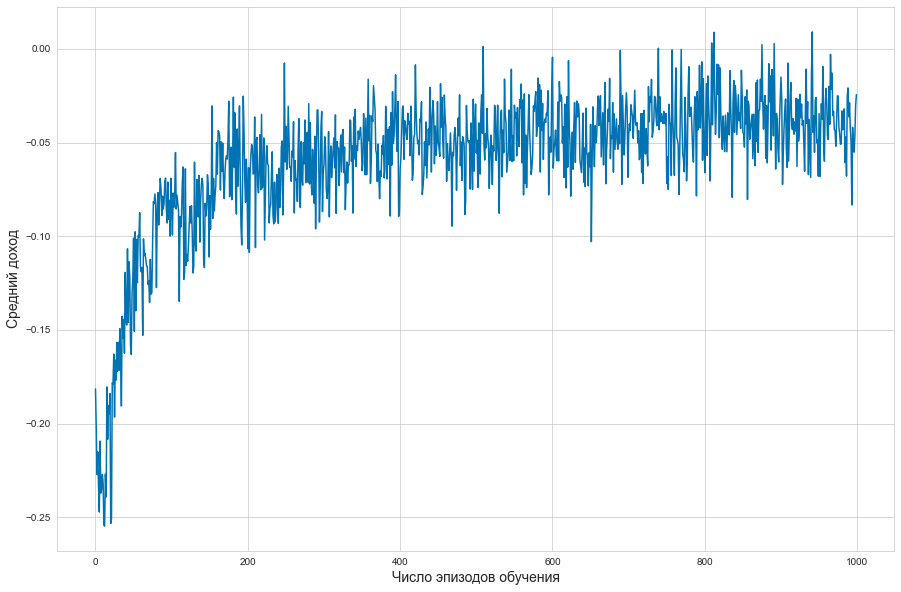

In [111]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_xlabel("Число эпизодов обучения", fontsize=14)
ax.set_ylabel("Средний доход", fontsize=14)

ax.plot(range(total_episodes), mean_episodes_reward)

plt.show()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

6) Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

7) Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [6]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


card2value = {1: -1, 2: 0.5, 3: 1, 4: 1, 5: 1.5, 6: 1, 7: 0.5, 8: 0, 9: -0.5, 10: -1}


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackDoubleCountingEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=True, sab=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (
                spaces.Discrete(32),
                spaces.Discrete(11),
                spaces.Discrete(2),
                spaces.Discrete(89),
            )
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.deck = deck * 4

        self.count = 0

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        return card

    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]

    #     def count_cards(cards):
    #         for card in cards:
    #             self.count += card2value[card]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            player_card = self.draw_card(self.np_random)
            self.player.append(player_card)
            self.count += card2value[player_card]
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 2:  # double
            done = True
            player_card = self.draw_card(self.np_random)
            self.player.append(player_card)
            self.count += card2value[player_card]

            self.count += card2value[self.dealer[1]]
            while sum_hand(self.dealer) < 17:
                dealer_card = self.draw_card(self.np_random)
                self.dealer.append(dealer_card)
                self.count += card2value[dealer_card]
            reward = cmp(score(self.player), score(self.dealer)) * 2
        else:  # stick: play out the dealers hand, and score
            done = True
            self.count += card2value[self.dealer[1]]
            while sum_hand(self.dealer) < 17:
                dealer_card = self.draw_card(self.np_random)
                self.dealer.append(dealer_card)
                self.count += card2value[dealer_card]
            reward = cmp(score(self.player), score(self.dealer))
            if (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (
            sum_hand(self.player),
            self.dealer[0],
            usable_ace(self.player),
            self.count,
        )

    def reset(self):
        if len(self.deck) < 15:
            self.deck = deck * 4
            self.count = 0
        self.dealer = self.draw_hand(self.np_random)
        self.count += card2value[self.dealer[0]]
        self.player = self.draw_hand(self.np_random)
        for card in self.player:
            self.count += card2value[card]
        return self._get_obs()

In [7]:
env = BlackjackDoubleCountingEnv(natural=True)

In [8]:
# запишем все возможные состояния и действия

A = [1, 0, 2]
S = []
min_player_hand = 4
max_player_hand = 31
min_dealer_hand = 1
max_dealer_hand = 10
for i in range(min_player_hand, max_player_hand + 1):
    for j in range(min_dealer_hand, max_dealer_hand + 1):
        for k in np.arange(-22, 22.5, 0.5):
            if 12 <= i <= 21:
                S.append((i, j, True, k))
                S.append((i, j, False, k))
            else:
                S.append((i, j, False, k))

nS, nA = len(S), len(A)
S2idx = {s: i for i, s in enumerate(S)}

In [9]:
total_episodes = 500_000
alpha = 0.0002
epsilon = 0.9
gamma = 1
Q = Q_learning(
    env, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma
)
pi = compute_policy_by_Q(env, Q)

num_experiments = 500_000
mean_reward = conduct_experiments_pi(env, pi, num_experiments)
print(f"Средний выигрыш от стратегии с удвоением и подсчетом Q-learning равен {mean_reward}")

Средний выигрыш от стратегии с удвоением и подсчетом Q-learning равен -0.039956


Подбор гиперпараметров:

In [10]:
epsilon = np.arange(0.85, 1, 0.05)
alpha = [0.00001, 0.00003, 0.00005]
for e in tqdm(epsilon):
    for a in alpha:
        Q = Q_learning(
            env, total_episodes=total_episodes, alpha=a, epsilon=e, gamma=gamma
        )
        pi = compute_policy_by_Q(env, Q)
        num_experiments = 50_000
        mean_reward = conduct_experiments_pi(env, pi, num_experiments)
        print(f"Epsillon = {e}, alpha = {a}, reward = {mean_reward}")

  0%|          | 0/4 [00:00<?, ?it/s]

Epsillon = 0.85, alpha = 1e-05, reward = -0.03254
Epsillon = 0.85, alpha = 3e-05, reward = -0.0329


 25%|██▌       | 1/4 [07:00<21:02, 420.79s/it]

Epsillon = 0.85, alpha = 5e-05, reward = -0.04485
Epsillon = 0.9, alpha = 1e-05, reward = -0.04276
Epsillon = 0.9, alpha = 3e-05, reward = -0.03155


 50%|█████     | 2/4 [14:09<14:10, 425.21s/it]

Epsillon = 0.9, alpha = 5e-05, reward = -0.03309
Epsillon = 0.9500000000000001, alpha = 1e-05, reward = -0.0423
Epsillon = 0.9500000000000001, alpha = 3e-05, reward = -0.03932


 75%|███████▌  | 3/4 [21:25<07:10, 430.37s/it]

Epsillon = 0.9500000000000001, alpha = 5e-05, reward = -0.04547
Epsillon = 1.0, alpha = 1e-05, reward = -0.04529
Epsillon = 1.0, alpha = 3e-05, reward = -0.04823


100%|██████████| 4/4 [28:38<00:00, 429.61s/it]

Epsillon = 1.0, alpha = 5e-05, reward = -0.04502


In [10]:
total_episodes = 100_000
alpha = 3e-05
epsilon = 0.9
gamma = 1
Q = Q_learning(
    env, total_episodes=total_episodes, alpha=alpha, epsilon=epsilon, gamma=gamma
)
pi = compute_policy_by_Q(env, Q)

num_experiments = 500_000
mean_reward = conduct_experiments_pi(env, pi, num_experiments)
print(f"Средний выигрыш от стратегии с удвоением и подсчетом Q-learning с подобранными гиперпараметрами равен {mean_reward}")

Средний выигрыш от стратегии с удвоением и подсчетом Q-learning с подобранными гиперпараметрами равен -0.021387


In [12]:
total_episodes = 1000
total_distribution = 50
mean_episodes_reward = plot_learning(total_episodes, total_distribution, 3e-05, 0.9)

100%|██████████| 1000/1000 [06:23<00:00,  2.61it/s]


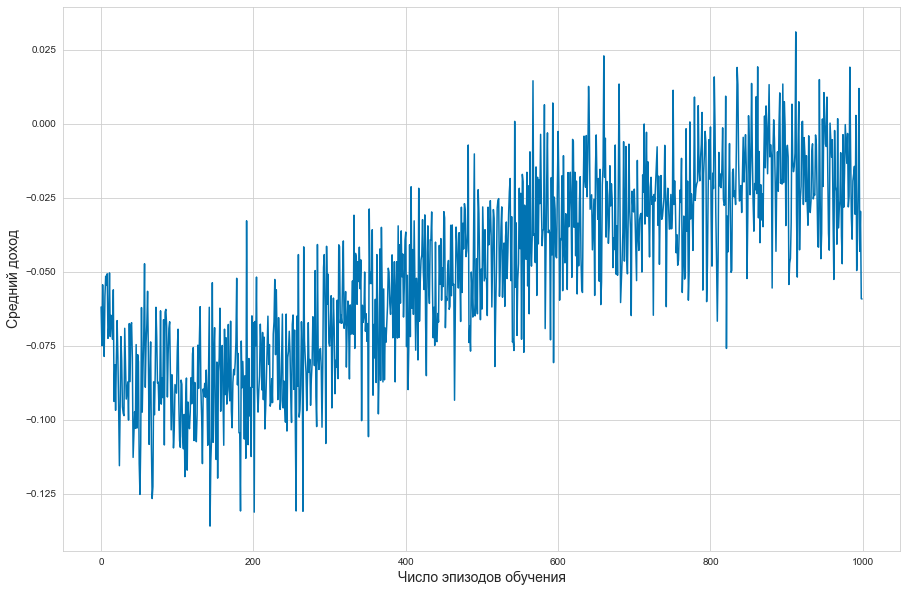

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.set_xlabel("Число эпизодов обучения", fontsize=14)
ax.set_ylabel("Средний доход", fontsize=14)

ax.plot(range(total_episodes), mean_episodes_reward)

plt.show()